In [193]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from book_palette import pal

### Parameters

In [194]:
# model parameters
r = 0.3                     # [m]
m = 2.0                     # [kg]
g = 9.81                    # [N/kg]
i = 0.335                  
j = 0.667
ωp = np.sqrt(g/r)           # [rad/s]

# simulation parameters
tf = 100                    # [s]
t = np.linspace(0, tf, 100000)

# steady state solution - dynamic equilibrium state
Φ = 5 * np.pi/180           # [rad]
Ω_3 = np.pi/6               # [rad/s]
Ω_2 = (i * Ω_3 * np.tan(Φ) - (g/(r*Ω_3)) * np.sin(Φ))/(j+1)     
                            # [rad/s] 
x_eq = np.array([Φ, 0, Ω_2, Ω_3])  

# initial conditions
dφ_0 = 0.02                 # initial disturbance in φ
ω1_0 = -0.10                # initial value of ω1
dω2_0 = 0.02                # initial disturbance in ω2
dω3_0 = 0.02                # initial disturbance in ω3

x0_N = np.array([Φ * (1 + dφ_0), ω1_0, Ω_2 * (1 + dω2_0), Ω_3 * (1 + dω3_0)])
x0_L = x0_N - x_eq

In [195]:
x_eq

array([ 0.08726646,  0.        , -3.25599237,  0.52359878])

### Nonlinear model in state space form

In [196]:
# non-linear model in state space form
def N_disc_model(t, x):
    return [x[1], 
          ((g/r)*np.sin(x[0]) + (j+1)*x[2]*x[3] - i*np.tan(x[0])*x[3]*x[3])/(i+1), 
          -x[1]*x[3]/(j+1), 
          x[1]*(-(j/i)*x[2] + np.tan(x[0])*x[3])]

In [197]:
# kinematic equations of motion
def N_disc_kinematics(t, q, f):
    x = f(t)
    ωs = (x[2]-x[3]*np.tan(x[0]))
    return [-r*ωs*np.cos(q[2]), 
          -r*ωs*np.sin(q[2]),
          -x[3]/np.cos(x[0]), 
          ωs]

In [198]:
# testing for the dynamic equilibrium state
N_disc_model(0, x_eq)

[0.0, -2.3389530013170434e-17, -0.0, 0.0]

### Linearized model in state space form

In [199]:
# state matrix
A = np.array([
    [0, 1, 0, 0],
    [(np.cos(Φ) * ((g/r) - i * Ω_3**2 / np.cos(Φ)**3)) / (i + 1), 0, (j + 1) / (i + 1) * Ω_3 , - (np.sin(Φ) * (i * Ω_3**2 / np.cos(Φ) + (g/r))) / ((i + 1) * Ω_3)],
    [0, -Ω_3 / (j + 1), 0, 0],
    [0, (i * Ω_3**2 * np.tan(Φ) + j * (g/r) * np.sin(Φ)) / (i * (j + 1) * Ω_3), 0, 0],
    ])

# non-linear model in state space form
def L_disc_model(t, x):
    return np.matmul(A, x)

In [200]:
# kinematic equations of motion
def L_disc_kinematics(t, q, f):
    x = f(t) + x_eq
    ωs = (x[2]-x[3]*np.tan(x[0]))
    return [-r*ωs*np.cos(q[2]), 
          -r*ωs*np.sin(q[2]),
          -x[3]/np.cos(x[0]), 
          ωs]

### Kinematic equations of motion

### Numerical Simulations

Nonlinear model

In [201]:
# solving the state space non-linear ODEs using solve_ivp function
s_N = solve_ivp(N_disc_model, [0, tf], x0_N, method='DOP853', dense_output=True)
x_N = s_N.sol(t)

In [202]:
# solving the kinematic non-linear ODEs using solve_ivp function
sk_N = solve_ivp(N_disc_kinematics, [0, tf], [0, 0, 0, 0], args=(s_N.sol,), method='DOP853', dense_output=True)
xk_N = sk_N.sol(t)

Linearized model

In [203]:
# solving the state space linearized model
s_L = solve_ivp(L_disc_model, [0, tf], x0_L, method='DOP853', dense_output=True)
x_L = s_L.sol(t)

In [204]:
# solving the kinematic non-linear ODEs using solve_ivp function
sk_L = solve_ivp(L_disc_kinematics, [0, tf], [0, 0, 0, 0], args=(s_L.sol,), method='DOP853', dense_output=True)
xk_L = sk_L.sol(t)

Plots

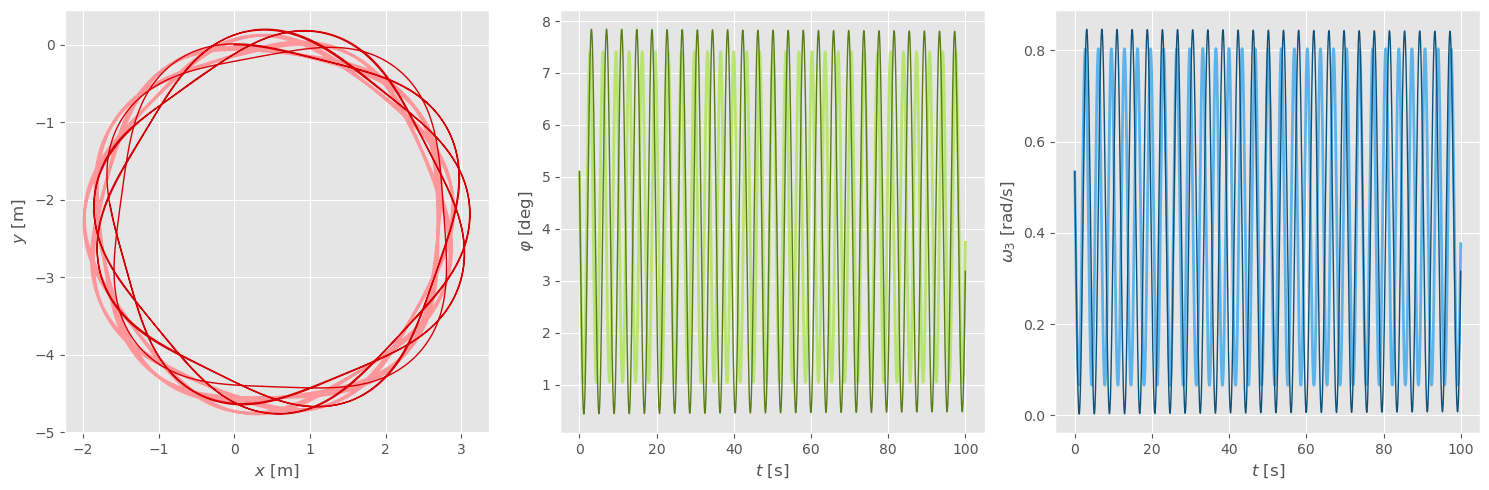

In [205]:
# Create a figure with subplots
plt.style.use('ggplot')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].plot(xk_N[0], xk_N[1], color=pal["lightred"], lw=2)
axs[0].plot(xk_L[0], xk_L[1], color=pal["darkred"], lw=1)
axs[0].set_xlabel(r'$x$ [m]')
axs[0].set_ylabel(r'$y$ [m]')
axs[1].plot(t, x_N[0] * 180/np.pi, color=pal["lightgreen"], lw=2)
axs[1].plot(t, (x_L[0] + x_eq[0]) * 180/np.pi, color=pal["darkgreen"], lw=1)
axs[1].set_xlabel(r'$t$ [s]')
axs[1].set_ylabel(r'$φ$ [deg]')
axs[2].plot(t, x_N[3], color=pal["lightblue"], lw=2)
axs[2].plot(t, x_L[3] + x_eq[3], color=pal["darkblue"], lw=1)
axs[2].set_xlabel(r'$t$ [s]')
axs[2].set_ylabel(r'$ω_3$ [rad/s]')


# Adjust the layout and spacing
fig.tight_layout()

plt.savefig('disc_sim.png', dpi=450)

# Show the plot
plt.show()

Mechanical energy conservation
$$ e = \frac{E}{m r^2} = \frac{T+V}{m r^2} $$

In [217]:
def e(x):
    return (0.5*((i+1)*x[1]*x[1] + (j+1)*x[2]*x[2] + i*x[3]*x[3]) + (g/r) * np.cos(x[0]))

e0 = e(x0_N)
Δe_N = [e(x) for x in x_N.T] - e0
Δe_L = [e(x + x_eq) for x in x_L.T] - e0

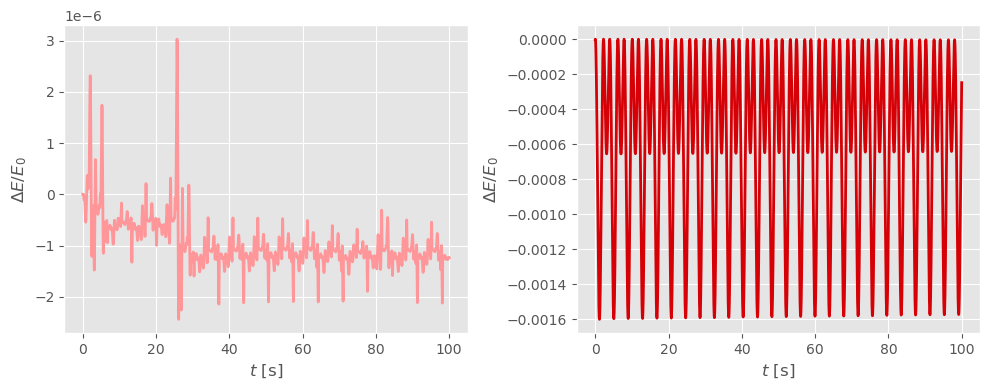

In [228]:
# Create a figure with subplots
plt.style.use('ggplot')
fig, axs_e = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs_e[0].plot(t, Δe_N/e0, color=pal["lightred"], lw=2)
axs_e[0].set_xlabel(r'$t$ [s]')
axs_e[0].set_ylabel(r'$ΔE/E_0$')
axs_e[1].plot(t, Δe_L/e0, color=pal["darkred"], lw=2)
axs_e[1].set_xlabel(r'$t$ [s]')
axs_e[1].set_ylabel(r'$ΔE/E_0$')

# Adjust the layout and spacing
fig.tight_layout()

# Show the plot
plt.show()